In [1]:
from datasets import load_dataset
import ast

dataset = load_dataset("hipe/2022-data", dataset='hipe2020', language='fr')

# Convert the 'metadata' string to a dictionary for each entry in the dataset
for i, item in enumerate(dataset['train']):
    metadata_string = item['metadata']
    metadata_dict = ast.literal_eval(metadata_string)
    dataset['train'][i]['metadata'] = metadata_dict

# Example usage
print(dataset['train'][0]['sentences']['tokens'][0])  # Tokens of the first sentence in the first article
print(dataset['train'][0]['sentences']['NE-COARSE-LIT'][0])  # Coarse labels for the tokens in the first sentence
print(dataset['train'][0]['metadata'])  # Metadata as a dictionary


['NOUVELLES', 'SUISSES', '—', 'En', '1887', ',', 'la', 'Société', 'suisse', 'du', 'Grutli', 's', "'", 'est', 'accrue', 'de', '40', 'sections', ';', 'l', "'", 'association', 'compte', 'actuellement', '12,000', 'membres']
['O', 'O', 'O', 'B-time', 'I-time', 'O', 'O', 'B-org', 'I-org', 'I-org', 'I-org', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
{'date': '1888-01-09', 'language': 'fr', 'document_type': 'newspaper', 'dataset': 'hipe2020', 'original_source': 'v1.4.1/fr/HIPE-data-v1.4.1-train-fr.tsv', 'doi': 'https://zenodo.org/record/6046853', 'version': 'v1.4', 'original_license': 'CC-BY-NC-SA 4.0', 'publication_title': 'EXP'}


In [2]:
WHITESPACE_RULES = {
    "fr": {
        "punctuation_nows_before": [".", ",", ")", "]", "}", "°", "..."],
        "punctuation_nows_after": ["(", "[", "{"],
        "punctuation_nows_beforeafter": ["'", "-"],
        "punctuation_ciffre": [".", ","],
    }
}

def reglue_tokenized_text(tokens: list[str]) -> str:
    """Reglue a tokenized text back together.

    Args:
        tokens (list[str]): List of tokens.
        language (str): Language of the text.

    Returns:
        str: Reglued text.
    """
    if not tokens:
        return ""

    # if language not in WHITESPACE_RULES:
    #     # Default behavior for languages without specific rules: join with space
    #     return " ".join(tokens)

    wsrules = WHITESPACE_RULES["fr"]
    text = tokens[0]

    for i in range(1, len(tokens)):
        prev_token = tokens[i - 1]
        curr_token = tokens[i]
        insert_ws = True

        if (
            prev_token in wsrules["punctuation_nows_beforeafter"]
            or curr_token in wsrules["punctuation_nows_beforeafter"]
        ):
            insert_ws = False

        elif curr_token in wsrules["punctuation_nows_before"]:
            insert_ws = False

        elif prev_token in wsrules["punctuation_nows_after"]:
            insert_ws = False

        elif (
            prev_token in wsrules["punctuation_ciffre"]
            and i >= 2
            and tokens[i - 2].isdigit()
            and curr_token.isdigit()
        ):
            insert_ws = False

        text += " " + curr_token if insert_ws else curr_token

    return text


In [3]:
from transformers import Pipeline
import numpy as np
import torch
from nltk.chunk import conlltags2tree
from nltk import pos_tag
from nltk.tree import Tree
import string
import torch.nn.functional as F
import re

In [30]:
from wikidata.client import Client

client = Client()
entity = client.get('Q70', load=True)

url = entity.data['sitelinks']['frwiki']['url']

print(url)

https://fr.wikipedia.org/wiki/Berne


In [31]:
def get_entities(tokens, tags, nel_lit, nel_meto):
    """postprocess the outputs here, for example, convert predictions to labels
    [
        {
            "entity": "B-org.ent.pressagency.AFP",
            "score": 0.99669313,
            "index": 13,
            "word": "AF",
            "start": 43,
            "end": 45,
        },
        {
            "entity": "I-org.ent.pressagency.AFP",
            "score": 0.42747754,
            "index": 14,
            "word": "##P",
            "start": 45,
            "end": 46,
        },
    ]
    [[('AFP', 'org.ent.pressagency.AFP', (12, 13), (47, 50))]]
    """
    tags = [tag.replace("S-", "B-").replace("E-", "I-") for tag in tags]
    pos_tags = [pos for token, pos in pos_tag(tokens)]

    conlltags = [(token, pos, tg) for token, pos, tg in zip(tokens, pos_tags, tags)]
    ne_tree = conlltags2tree(conlltags)

    entities = []
    idx: int = 0

    for subtree in ne_tree:
        if isinstance(subtree, Tree):
            original_label = subtree.label()
            original_string = " ".join([token for token, pos in subtree.leaves()])
            
            if nel_lit[idx] not in ['NIL', '_']:
                qid = nel_lit[idx]
                entity = client.get('Q70', load=True)
                correct_name = entity.data['labels']['fr']['value']
                entities.append(
                    {
                        "index": idx,
                        "entity": original_label,
                        "word": original_string,
                        "qid": qid,
                        "wikipedia": correct_name
                    }
                )
            else:
                entities.append(
                    {
                        "index": idx,
                        "entity": original_label,
                        "word": original_string,
                    }
                )
            idx += len(subtree)

            # Update the current character position
            # We add the length of the original string + 1 (for the space)
        else:
            token, pos = subtree
            # If it's not a named entity, we still need to update the character
            # position
            idx += 1

    return entities

In [5]:
def get_detail(original_string, entities, detail_type):
    """
    Get the function for a person from a list of entities.

    :param original_string: The original string representing a person.
    :param entities: A list of entities, where each entity is represented as
                     a list [text, type, start_position, end_position].
    :return: The function of the person if found, otherwise None.
    """
#     {'index': 18, 'entity': 'time', 'word': 'du 17 novembre 1885'}
#     print(entities)
#     print(original_string, detail_type)
    
    for entity in entities:
        entity_text, entity_type = entity['word'], entity['entity']
        if detail_type in entity_type and entity_text in original_string:
#             print(entity['word'])
#             print('-'*30)
            return entity['word']
#     print('-'*30)
    return None

In [6]:
# import ast

# for document in dataset['train']:
#     sentences = document['sentences']
#     metadata = ast.literal_eval(document['metadata'])
#     print(type(metadata))
    
#     # Extract the date from the metadata
#     date = metadata.get('date', 'Unknown Date')
    
#     for tokens, coarse_lit, coarse_meto, fine_lit, file_meto, fine_comp, ne_nested in zip(sentences['tokens'], 
#                              sentences['NE-COARSE-LIT'], sentences['NE-COARSE-METO'], sentences['NE-FINE-LIT'], 
#                              sentences['NE-FINE-METO'], sentences['NE-FINE-COMP'], sentences['NE-NESTED']):
#         entities = [get_entities(tokens, tags) for tags in [coarse_lit, coarse_meto, fine_lit, file_meto, fine_comp, ne_nested]]

#         print(f"Date: {date}, Entities: {entities}")

In [9]:
import ast
from collections import defaultdict
from tqdm import tqdm

# Assuming dataset and get_entities are already defined

# Dictionaries to store entity statistics
entities_per_year = defaultdict(int)
entities_per_decade = defaultdict(int)
entity_decade_appearances = defaultdict(set)
entity_year_appearances = defaultdict(set)  # To track in which years each entity appears
unique_entity_types = set()  # To track unique entity types

for document in tqdm(dataset['train'], total=len(dataset['train'])):
    metadata = ast.literal_eval(document['metadata'])
    date = metadata.get('date')
    
    if not date:
        continue  # Skip documents without a date

    year = int(date[:4])
    decade = year - (year % 10)

    sentences = document['sentences']
    entities = []
    for tokens, coarse_lit, coarse_meto, fine_lit, fine_meto, fine_comp, ne_nested, nel_lit, nel_meto in zip(
        sentences['tokens'], sentences['NE-COARSE-LIT'], sentences['NE-COARSE-METO'],
        sentences['NE-FINE-LIT'], sentences['NE-FINE-METO'], sentences['NE-FINE-COMP'], sentences['NE-NESTED'],
        sentences['NEL-LIT'], sentences['NEL-METO']
    ):
        for tags in [fine_lit, fine_meto, fine_comp, ne_nested]:
            entities += get_entities(tokens, tags, nel_lit, nel_meto)

    for entity in entities:
        entity_type = entity['entity']
        entity_name = entity['word']
        unique_entity_types.add(entity_type)  # Track the entity type

        function, name = None, None
        if "pers" in entity_type:
            function = get_detail(entity_name, entities, "function")
            name = get_detail(entity_name, entities, "name")

        entities_per_year[(entity_name, year, entity_type, function, name)] += 1
        entities_per_decade[(entity_name, decade, entity_type, function, name)] += 1
        entity_decade_appearances[entity_name].add(decade)
        entity_year_appearances[entity_name].add(year)

# Print statistics
# print("Entities per year:")
# for (entity, year, entity_type, function, name), count in entities_per_year.items():
#     print(f"{entity} in {year} ({entity_type}, {function}, {name}): {count}")

# print("Entities per decade:")
# for (entity, decade, entity_type, function, name), count in entities_per_decade.items():
#     print(f"{entity} in {decade}s ({entity_type}, {function}, {name}): {count}")

# print("Entities mentioned in multiple decades:")
# for entity, decades in entity_decade_appearances.items():
#     if len(decades) > 1:
#         print(f"{entity} appears in decades: {sorted(decades)}")

# print("Entities mentioned in multiple years:")
# for entity, years in entity_year_appearances.items():
#     if len(years) > 1:
#         print(f"{entity} appears in years: {sorted(years)}")

# Print unique entity types
print("Unique entity types:")
for entity_type in unique_entity_types:
    print(entity_type)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:18<00:00,  8.55it/s]

Unique entity types:
loc.phys.hydro
loc.oro
prod.doctr
pers.coll
comp.function
loc.adm.town
org.ent.pressagency
comp.title
loc.add.elec
loc.phys.geo
pers.ind
loc.unk
prod.media
time.date.abs
loc.adm.reg
loc.adm.sup
org.adm
comp.demonym
org.ent
comp.qualifier
loc.adm.nat
loc.fac
loc.add.phys
pers.ind.articleauthor
comp.name


In [10]:
print("Entities mentioned in multiple years:")
for entity, years in entity_year_appearances.items():
    if len(years) > 1:
        entity = reglue_tokenized_text(entity.split())
        print(f"{entity} appears in years: {sorted(years)}")


Entities mentioned in multiple years:
Berne appears in years: [1798, 1808, 1858, 1868, 1888, 1898, 1908, 1918, 1928, 1938, 1948, 1958, 1968, 1978, 1988]
Genève appears in years: [1828, 1848, 1858, 1868, 1888, 1898, 1908, 1918, 1928, 1938, 1948, 1958, 1968, 1978, 1988]
Lausanne appears in years: [1828, 1868, 1888, 1898, 1918, 1938, 1948, 1958, 1968, 1978, 1988, 1998]
Rome appears in years: [1828, 1878, 1888, 1898, 1938]
Echallens appears in years: [1828, 1888, 1968]
Fribourg appears in years: [1798, 1848, 1868, 1888, 1928, 1958, 1968]
France appears in years: [1808, 1818, 1828, 1858, 1868, 1878, 1888, 1898, 1908, 1918, 1928, 1938, 1948, 1988, 1998]
Suisse appears in years: [1828, 1848, 1858, 1868, 1888, 1898, 1908, 1918, 1928, 1938, 1948, 1958, 1968, 1978, 1988]
Savoie appears in years: [1888, 1908]
M. appears in years: [1808, 1828, 1838, 1848, 1858, 1868, 1878, 1888, 1898, 1908, 1918, 1928, 1938, 1948, 1958, 1968, 1978, 1988]
M. J appears in years: [1888, 1948, 1978]
J appears in years

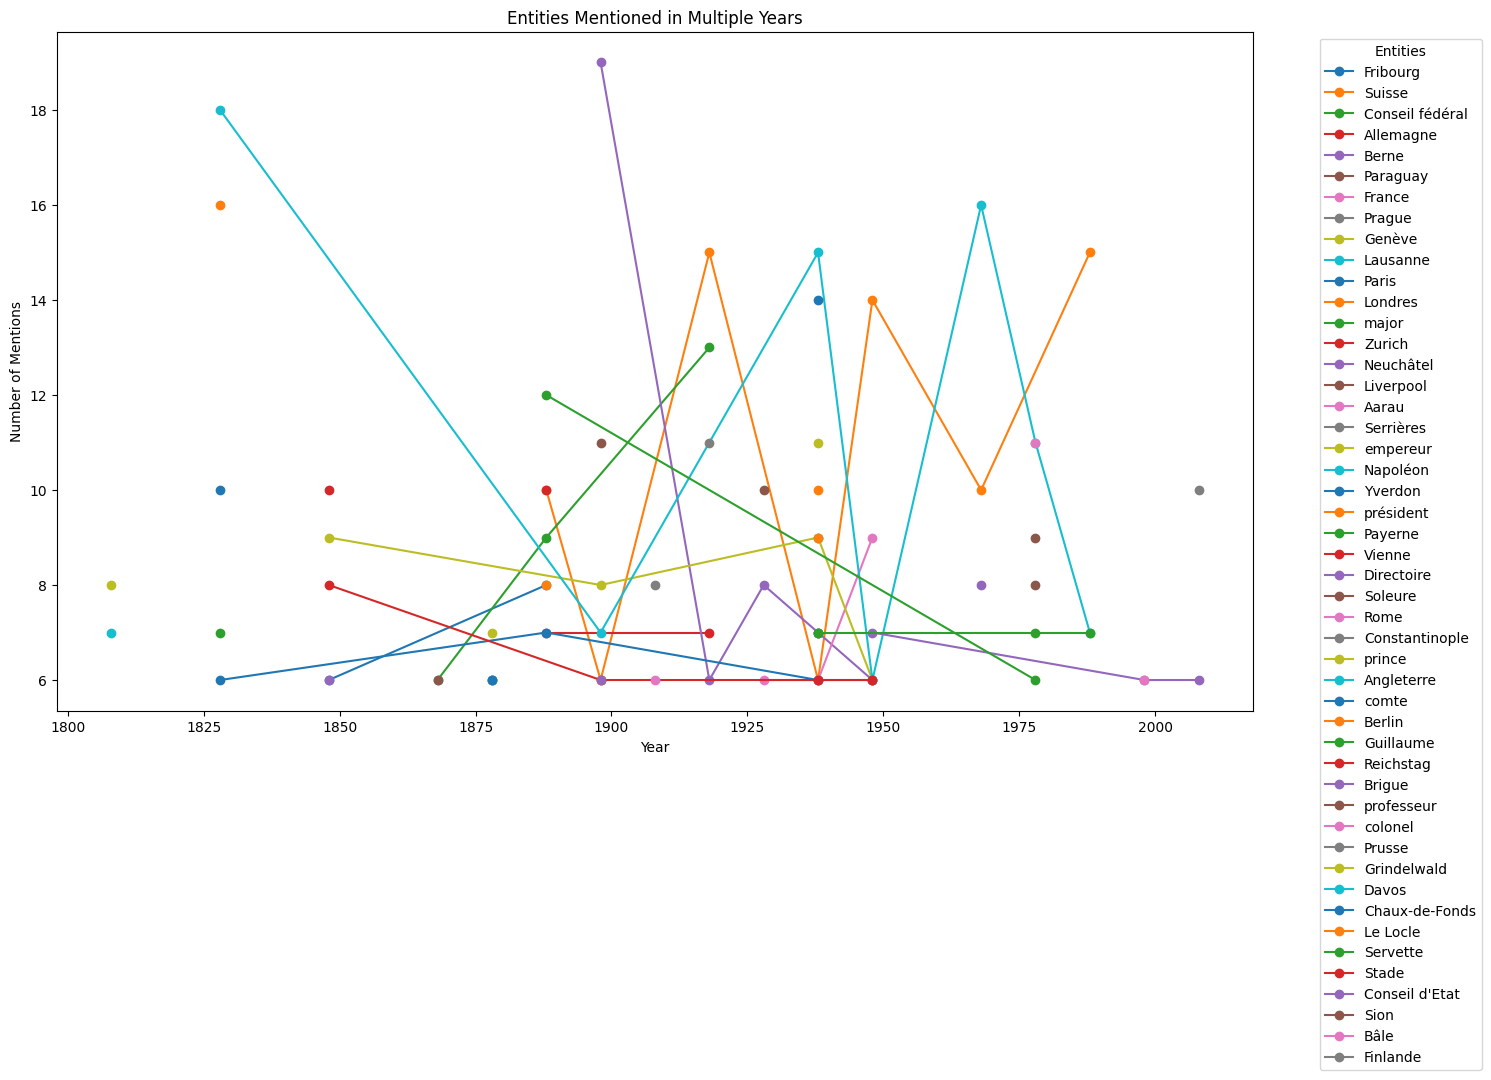

In [11]:
import matplotlib.pyplot as plt

# Filter entities mentioned in multiple years and prepare data for plotting
entity_year_counts = {}
for (entity, year, entity_type, name, function), count in entities_per_year.items():
    
    if entity in entity_year_appearances and len(entity_year_appearances[entity]) > 1:
        entity = reglue_tokenized_text(entity.split())
        if len(entity) > 2:
            if count > 5:
                if entity not in entity_year_counts:
                    entity_year_counts[entity] = {}
                entity_year_counts[entity][year] = count

# Plotting each entity's mentions per year
plt.figure(figsize=(15, 10))
for entity, year_counts in entity_year_counts.items():
    years = sorted(year_counts.keys())
    counts = [year_counts[year] for year in years]
    plt.plot(years, counts, marker='o', label=entity)

plt.xlabel('Year')
plt.ylabel('Number of Mentions')
plt.title('Entities Mentioned in Multiple Years')
plt.legend(title='Entities', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [12]:
places = []
for (entity, year, entity_type, name, function), count in entities_per_year.items():
    if 'loc' in entity_type:
        places.append(entity)
        
print(list(set(places)))

['Marnand', 'Bourgogne', 'Orly', 'Lucens', 'Grancy', 'Pesth', 'plovelier', 'Sarragosse', 'Beau - Rivage', 'Mur de Grammont', "Bosnie et l ' Herzégovine", 'Wagram', 'ROME', 'ferme des Loges', 'Vtvej', 'commune du Sentier', 'HONGRIE', 'tunnel du Hauenstein', 'Hanau', 'Moud', 'outre - Rhin', 'Weftphalie', 'Palais - Bourbon', 'Me * klenbourg - Schwerin', 'Faverois', 'château de la Aljaferia', 'boulevard Montmartre', 'République Françaife', 'Joux de Provence', 'Presbonrg', 'Scandinave', 'Versailles', 'Limmat', 'Baden', 'Frutigen', 'Karlsbad', 'Pologne', 'Orbe', 'Montlingen', 'Austerlirz', 'Extréme - Asie', 'Navarin', 'diftàBadcn', 'Bussie', 'Pruth', 'Suisse centrale', 'Esclavouie', 'Chicago', 'Tiflis', 'Théâtre de Beaulieu', 'Bremgarten', 'Genève', 'Corinthe', 'Moral', 'Nouvelle Galles du Sud', 'Pau', 'LisBOKNE', 'Abyssinie', 'Pays - Bas', 'Plancemont', 'Arlberg', 'Linz', 'Peney', 'Orient', 'Ville de Lausanne', 'FAreuse', 'WURZEOURG', 'àMartinsbruck', 'Sarine', 'Vallée de Joux', 'Glana :', 

In [13]:
persons = []
for (entity, year, entity_type, name, function), count in entities_per_year.items():
    if 'pers' in entity_type:
        persons.append((entity, year, entity_type, name, function))
        
for person in list(set(persons)):
    print(person)

('Charles Spaak', 1948, 'pers.ind', None, None)
('Mr', 1808, 'pers.ind', None, None)
("M . de Campuzano , ambassadeur d ' Espagne à Paris", 1838, 'pers.ind', "ambassadeur d ' Espagne à Paris", 'de Campuzano')
('Pierre Deslandes', 1928, 'pers.ind', None, None)
('Khrouchtchev', 1968, 'pers.ind', None, None)
('Jean - David Rou - 1 ter', 1828, 'pers.ind', None, None)
('M . Ackermann , conservateur - libre', 1888, 'pers.ind', 'conservateur - libre', 'Ackermann')
('Zola', 1888, 'pers.ind', None, None)
('Francisco Marti', 1938, 'pers.ind', None, None)
('Marc - André Spahni', 1998, 'pers.ind', None, None)
('prince Karageorgevitch', 1878, 'pers.ind', None, 'Karageorgevitch')
('François Franzoni , avocat', 1828, 'pers.ind', 'avocat', 'François Franzoni')
('Ziegier - Pelltè', 1858, 'pers.ind', None, 'Ziegier - Pelltè')
('Henri Dunant', 1948, 'pers.ind', None, 'Henri Dunant')
('André Ramseyer', 1978, 'pers.ind', None, None)
('L -', 1948, 'pers.ind.articleauthor', None, None)
('M . Brosi', 1848, 'p

https://fr.wikipedia.org/wiki/Berne


In [25]:
entity.data.keys()

dict_keys(['pageid', 'ns', 'title', 'lastrevid', 'modified', 'type', 'id', 'labels', 'descriptions', 'aliases', 'claims', 'sitelinks'])

In [29]:
entity = client.get('Q70', load=True)
correct_name = entity.data['labels']['fr']['value']

In [ ]:
import pandas as pd
import ast
from tqdm import tqdm

# Assuming dataset and get_entities are already defined

# List to collect all the row data
data = []

for document in tqdm(dataset['train'], total=len(dataset['train'])):
    metadata = ast.literal_eval(document['metadata'])
    date = metadata.get('date')
    source = metadata.get('publication_title')
    language = metadata.get('language')
    doc_type = metadata.get('document_type')

    if not date:
        continue  # Skip documents without a date

    year = int(date[:4])
    decade = year - (year % 10)
    sentences_data = document['sentences']
    article_text = " ".join([" ".join(sentence) for sentence in sentences_data['tokens']])  # Concatenate all sentences

    for tokens, coarse_lit, coarse_meto, fine_lit, fine_meto, fine_comp, ne_nested, nel_lit, nel_meto in zip(
        sentences_data['tokens'], sentences_data['NE-COARSE-LIT'], sentences_data['NE-COARSE-METO'],
        sentences_data['NE-FINE-LIT'], sentences_data['NE-FINE-METO'], sentences_data['NE-FINE-COMP'], sentences_data['NE-NESTED'],
        sentences_data['NEL-LIT'], sentences_data['NEL-METO']
    ):
        sentence_text = " ".join(tokens)
        entities = []
        for tags in [fine_lit, fine_meto, fine_comp, ne_nested]:
            entities += get_entities(tokens, tags, nel_lit, nel_meto)

        # Append data for each sentence in the document
        data.append({
            'date': date,
            'source': source,
            'language': language,
            'doc_type': doc_type,
            'year': year,
            'decade': decade,
            'sentence': sentence_text,
            'entities': entities,
            'article': article_text
        })

# Create a DataFrame
df = pd.DataFrame(data)

 12%|████████████████████▍                                                                                                                                                     | 19/158 [16:59<2:30:43, 65.06s/it]

In [96]:
entities[0]

{'index': 5, 'entity': 'loc.adm.nat', 'word': 'Inde', 'qid': 'Q668'}

In [80]:
df.head()

,date,source,language,doc_type,year,decade,sentence,entities,article
0,1888-01-09,EXP,fr,newspaper,1888,1880,"NOUVELLES SUISSES — En 1887 , la Société suiss...","[{'index': 3, 'entity': 'time.date.abs', 'word...","NOUVELLES SUISSES — En 1887 , la Société suiss..."
1,1888-01-09,EXP,fr,newspaper,1888,1880,"Environ 30,000 fr . ont été versés dans la cai...",[],"NOUVELLES SUISSES — En 1887 , la Société suiss..."
2,1888-01-09,EXP,fr,newspaper,1888,1880,Ecoles de fonctionnaires,[],"NOUVELLES SUISSES — En 1887 , la Société suiss..."
3,1888-01-09,EXP,fr,newspaper,1888,1880,— On parle de fonder deux facultés de sciences...,"[{'index': 15, 'entity': 'loc.adm.town', 'word...","NOUVELLES SUISSES — En 1887 , la Société suiss..."
4,1888-01-09,EXP,fr,newspaper,1888,1880,Chemins de fer,[],"NOUVELLES SUISSES — En 1887 , la Société suiss..."


In [81]:
df.iloc[0].entities

[{'index': 3, 'entity': 'time.date.abs', 'word': 'En 1887'},
 {'index': 7, 'entity': 'org.ent', 'word': 'Société suisse du Grutli'},
 {'index': 10, 'entity': 'loc.phys.geo', 'word': 'Grutli'}]

In [82]:
df.tail()

,date,source,language,doc_type,year,decade,sentence,entities,article
5674,2018-01-03,IMP,fr,newspaper,2018,2010,Quelques courts ex - traits un peu au hasard,[],COURTS EXTRAITS Le carnet de bord des quatre b...
5675,2018-01-03,IMP,fr,newspaper,2018,2010,A l ’ entrée en Bulgarie : « La douane se pass...,"[{'index': 5, 'entity': 'loc.adm.nat', 'word':...",COURTS EXTRAITS Le carnet de bord des quatre b...
5676,2018-01-03,IMP,fr,newspaper,2018,2010,Sur un bateau au large de Bahreïn : « Les port...,"[{'index': 6, 'entity': 'loc.adm.nat', 'word':...",COURTS EXTRAITS Le carnet de bord des quatre b...
5677,2018-01-03,IMP,fr,newspaper,2018,2010,Impossible de leur faire comprendre qu ’ en Eu...,"[{'index': 8, 'entity': 'loc.adm.sup', 'word':...",COURTS EXTRAITS Le carnet de bord des quatre b...
5678,2018-01-03,IMP,fr,newspaper,2018,2010,» Chez le médecin en Inde : « Il y a un dispen...,"[{'index': 5, 'entity': 'loc.adm.nat', 'word':...",COURTS EXTRAITS Le carnet de bord des quatre b...


In [ ]:
# save in world_models/data/

In [63]:
# import geopy
# from geopy.geocoders import Nominatim
# from collections import defaultdict

# # Assuming you have a dataset where entities and their years are already extracted
# place_mentions_per_year = defaultdict(list)  # {year: [(place_name, entity)]}

# # Geolocator setup
# geolocator = Nominatim(user_agent="geoapiExercises")

# # Example dataset iteration
# for document in tqdm(dataset['train'], total=len(dataset['train'])):
#     metadata = ast.literal_eval(document['metadata'])
#     date = metadata.get('date')
    
#     if not date:
#         continue  # Skip documents without a date

#     year = int(date[:4])
#     decade = year - (year % 10)
    
#     sentences = document['sentences']
#     for tokens, coarse_lit, coarse_meto, fine_lit, fine_meto, fine_comp, ne_nested in zip(
#         sentences['tokens'], sentences['NE-COARSE-LIT'], sentences['NE-COARSE-METO'],
#         sentences['NE-FINE-LIT'], sentences['NE-FINE-METO'], sentences['NE-FINE-COMP'], sentences['NE-NESTED']
#     ):
#         for tags in [coarse_lit, coarse_meto, fine_lit, fine_meto, fine_comp, ne_nested]:
#             entities = get_entities(tokens, tags)
#             print(entities)
#             for entity in entities:
#                 if entity['entity'] == 'loc':  # Assuming 'type' field indicating the entity type
#                     location = geolocator.geocode(entity['word'], exactly_one=True)
#                     if location:
#                         lat, lon = location.latitude, location.longitude
#                         place_mentions_per_year[year].append((entity['word'], (lat, lon)))

# # Now place_mentions_per_year contains place names and their coordinates mentioned per year

# # Example: print places and their coordinates mentioned in 2020
# for place, coords in place_mentions_per_year[2020]:
#     print(f"{place} at coordinates {coords}")
